In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import layers, models, regularizers

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC


from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

from tensorflow.keras.models import load_model

In [137]:
train_data_dir= "../data/raw_data/Training"
test_data_dir = "../data/raw_data/Testing"

In [138]:
# Training and validation datasets
X_train = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,  # Use 20% of the data for validation
    subset="training",  # Specify the subset
    seed=42,  # Ensure reproducibility
    image_size=(128, 128),  # Resize images to 128x128
    batch_size=16  # Batch size
)

X_val = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,  # Use 20% of the data for validation
    subset="validation",  # Specify the subset
    seed=42,  # Ensure reproducibility
    image_size=(128, 128),  # Resize images to 128x128
    batch_size=16  # Batch size
)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [139]:
# Test dataset
X_test = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    image_size=(128, 128),  # Resize images to 128x128
    batch_size=16,  # Batch size
    shuffle=False
)

Found 1311 files belonging to 4 classes.


In [140]:
X_train_labels = X_train.class_names
X_val_labels = X_val.class_names
X_test_labels = X_val.class_names

In [141]:
# Normalize images to [0, 1]
def normalize_0_1(image, label):
    return image / 255.0, label

# Convert labels to one-hot encoding
def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=4)  # Convert label to one-hot encoding (4 classes)
    return image, label

In [142]:
# Apply the normalization and one-hot encoding to the datasets
X_train = X_train.map(normalize_0_1).map(one_hot_encode)
X_val = X_val.map(normalize_0_1).map(one_hot_encode)
X_test = X_test.map(normalize_0_1).map(one_hot_encode)

In [143]:
# Sequential model
model = models.Sequential()

In [45]:
# Input Layer (128x128x1)
model.add(layers.InputLayer(input_shape=(128, 128, 3)))

# Block 1 (3x3 Conv)
model.add(layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))

model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Block 2 (5x5 Conv)
model.add(layers.Conv2D(64, kernel_size=(5, 5), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model.add(layers.BatchNormalization())  # Added Batch Normalization
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Block 3 (3x3 Conv)
model.add(layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model.add(layers.BatchNormalization())  # Added Batch Normalization
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Block 4 (5x5 Conv)
model.add(layers.Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model.add(layers.BatchNormalization())  # Added Batch Normalization
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Block 5 (3x3 Conv)
model.add(layers.Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model.add(layers.BatchNormalization())  # Added Batch Normalization

# Global Average Pooling Layer
model.add(layers.GlobalAveragePooling2D())

# Dropout Layer
model.add(layers.Dropout(0.2))

# Dense Layer for Classification (4 classes: Glioma, Meningioma, Pituitary, No Tumor)
model.add(layers.Dense(4, activation='softmax', kernel_regularizer=regularizers.l2(0.001)))


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),  # Adjusted learning rate
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])

# Print model summary
model.summary()

/home/gokhan/.pyenv/versions/3.10.6/envs/brainmap/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,131,524 (8.13 MB)

 Trainable params: 2,129,604 (8.12 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [46]:
# Set up directories for saving the model and TensorBoard logs
checkpoint_dir = './checkpoints'
tensorboard_log_dir = './logs'

os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(tensorboard_log_dir, exist_ok=True)

In [47]:
callbacks = [
    # Save the model with the minimum valdiation loss
    ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'best_model.keras'),
                    monitor='val_loss', mode='min', save_best_only=True, verbose=1),

    # Early stopping to stop training when validation loss stops decreasing
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),

    # Reduce learning rate when the validation loss plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1),

    # TensorBoard logging
    TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=1, write_images=True)
]

In [48]:
# Training the model with callbacks and storing the training history
history = model.fit(
    X_train,  # Training data generator or dataset
    epochs=100,
    batch_size=16,
    validation_data=X_val,  # Validation data generator or dataset
    callbacks=callbacks
)

Epoch 1/100


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.7058 - auc: 0.9041 - loss: 1.3686 - precision: 0.7824 - recall: 0.6275
Epoch 1: val_loss improved from inf to 7.40275, saving model to ./checkpoints/best_model.keras
286/286 ━━━━━━━━━━━━━━━━━━━━ 142s 484ms/step - accuracy: 0.7061 - auc: 0.9042 - loss: 1.3680 - precision: 0.7826 - recall: 0.6279 - val_accuracy: 0.2636 - val_auc: 0.5403 - val_loss: 7.4028 - val_precision: 0.2636 - val_recall: 0.2636 - learning_rate: 1.0000e-04
Epoch 2/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.8424 - auc: 0.9706 - loss: 1.0208 - precision: 0.8701 - recall: 0.8220
Epoch 2: val_loss improved from 7.40275 to 1.39951, saving model to ./checkpoints/best_model.keras
286/286 ━━━━━━━━━━━━━━━━━━━━ 133s 464ms/step - accuracy: 0.8425 - auc: 0.9706 - loss: 1.0207 - precision: 0.8702 - recall: 0.8221 - val_accuracy: 0.7347 - val_auc: 0.9196 - val_loss: 1.3995 - val_precision: 0.7776 - val_recall: 0.7163 - learning_rate: 1.0000e-04
Epoch 3/100


In [144]:
# Find the index of the epoch with the minimum validation loss
best_epoch_index = np.argmin(history.history['val_loss'])

print(f"Best epoch (index) based on validation loss: {best_epoch_index}")

Best epoch (index) based on validation loss: 84


In [145]:
# Optionally, print specific metrics like accuracy, loss, and AUC
print("\nSpecific Metrics (Training & Validation):")
print(f"Training Accuracy: {history.history['accuracy'][best_epoch_index]}")
print(f"Validation Accuracy: {history.history['val_accuracy'][best_epoch_index]}")
print(f"Training Loss: {history.history['loss'][best_epoch_index]}")
print(f"Validation Loss: {history.history['val_loss'][best_epoch_index]}")
print(f"Training Precision: {history.history['precision'][best_epoch_index]}")
print(f"Validation Precision: {history.history['val_precision'][best_epoch_index]}")
print(f"Training Recall: {history.history['recall'][best_epoch_index]}")
print(f"Validation Recall: {history.history['val_recall'][best_epoch_index]}")
print(f"Training AUC: {history.history['auc'][best_epoch_index]}")
print(f"Validation AUC: {history.history['val_auc'][best_epoch_index]}")


Specific Metrics (Training & Validation):
Training Accuracy: 1.0
Validation Accuracy: 0.9746059775352478
Training Loss: 0.21234680712223053
Validation Loss: 0.296907901763916
Training Precision: 1.0
Validation Precision: 0.9746059775352478
Training Recall: 1.0
Validation Recall: 0.9746059775352478
Training AUC: 0.9999999403953552
Validation AUC: 0.9975305199623108


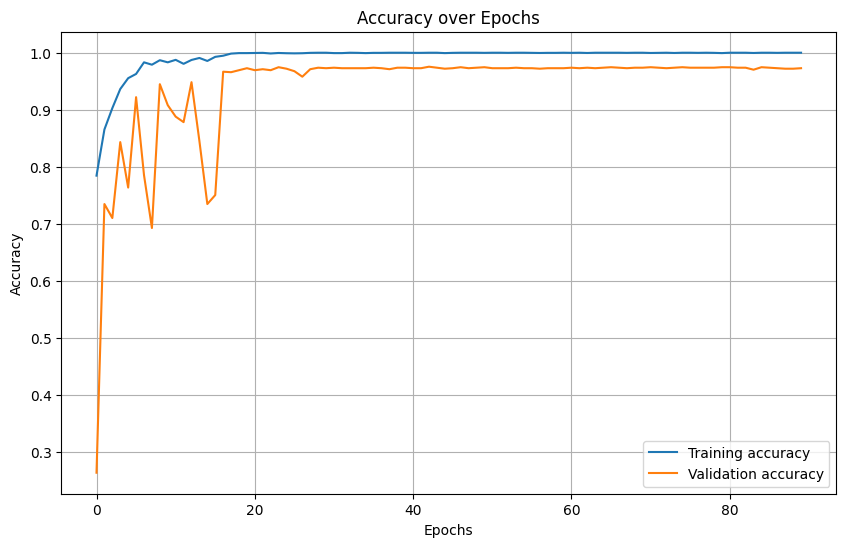

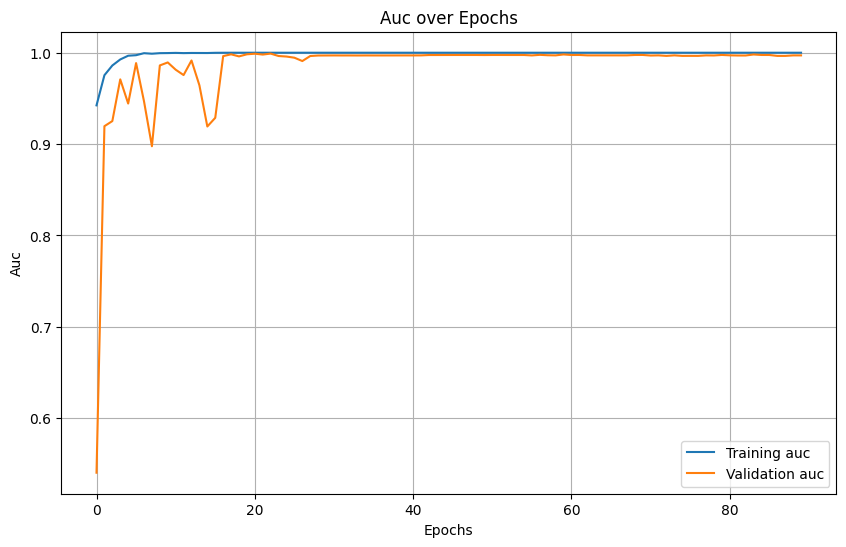

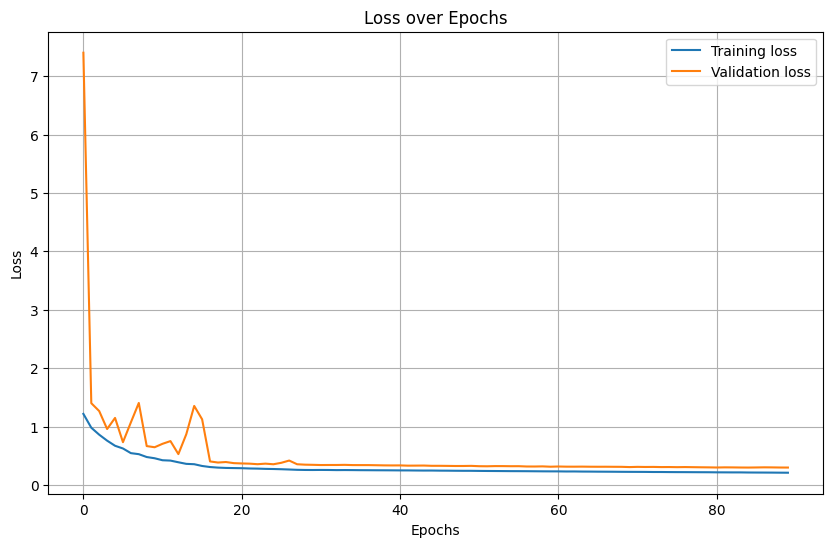

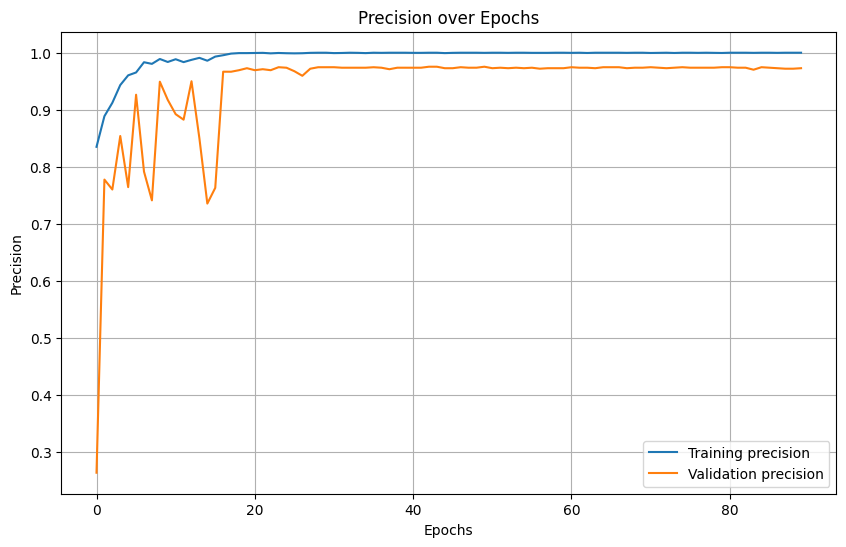

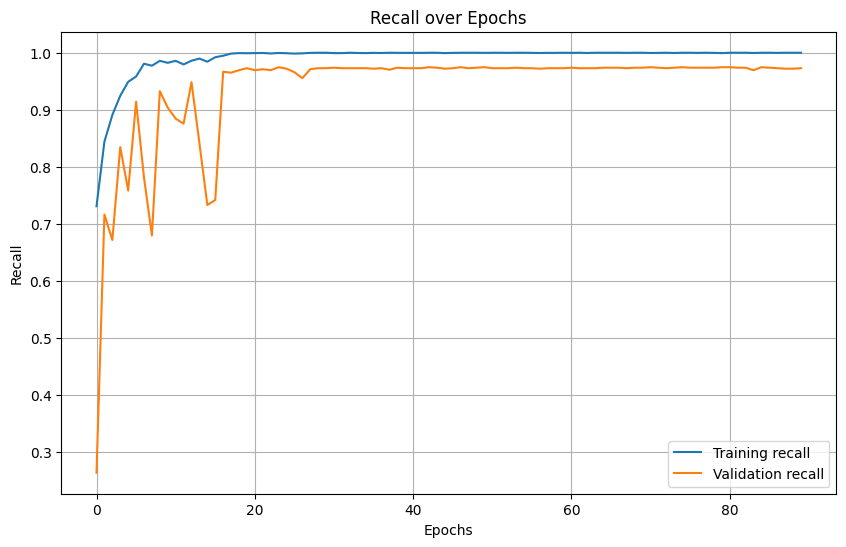

In [146]:
# Define the metrics to plot
metrics = ['accuracy', 'auc', 'loss', 'precision', 'recall']

# Plot each metric
for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[metric], label=f'Training {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.title(f'{metric.capitalize()} over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

In [147]:
# Load the best model
best_model_path = os.path.join(checkpoint_dir, 'best_model.keras')
best_model = load_model(best_model_path)

# Evaluate on test data
test_loss, test_accuracy, test_auc, test_precision, test_recall = best_model.evaluate(X_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")

82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.9574 - auc: 0.9891 - loss: 0.3873 - precision: 0.9574 - recall: 0.9574
Test Accuracy: 0.9748


In [148]:
from visualkeras import layered_view
from collections import defaultdict

/home/gokhan/.pyenv/versions/3.10.6/envs/brainmap/lib/python3.10/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


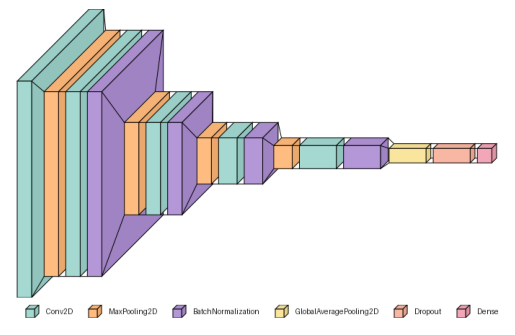

In [149]:
# Customize the color map for different layers
color_map = defaultdict(dict)
# Custom pastel colors
color_map[layers.Conv2D]['fill'] = "#A4D8D0"  # Light Teal (soft and calming)
color_map[layers.BatchNormalization]['fill'] = "#B497D7"  # Soft Lavender (smooth transition)
color_map[layers.MaxPooling2D]['fill'] = "#FFBC80"  # Light Orange (bright accent)
color_map[layers.GlobalAveragePooling2D]['fill'] = "#F9E59E"  # Soft Yellow (light and airy)
color_map[layers.Dropout]['fill'] = "#F7B7A3"  # Soft Peach (warm, welcoming)
color_map[layers.Dense]['fill'] = "#F1A7B7"  # Muted Coral (vibrant yet soft)

# Visualize the model architecture with the custom color map
img = layered_view(best_model, legend=True, max_xy=300, color_map=color_map)

# Display the image
plt.imshow(img)
plt.axis('off')  # Remove axis for cleaner display
plt.show()

In [150]:
# Get the class names from the test dataset
X_test_labels

['glioma', 'meningioma', 'notumor', 'pituitary']

82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step


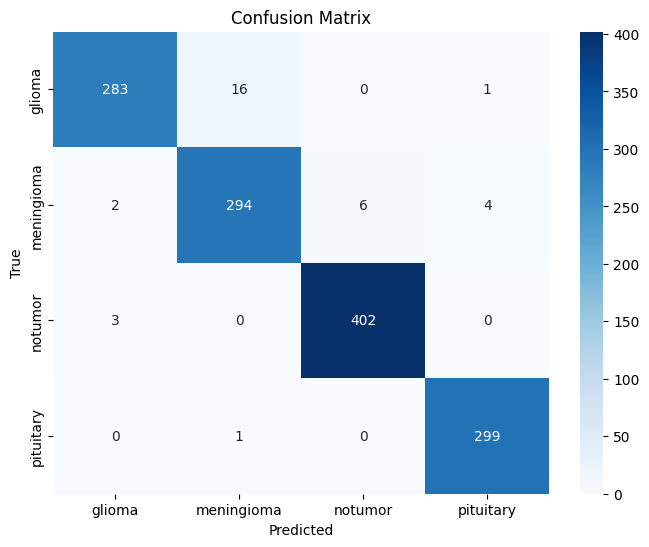

In [183]:
# Get the predicted probabilities for the test set
y_pred_proba = best_model.predict(X_test, verbose=1)

# Convert predicted probabilities to predicted class labels
y_pred_classes = np.argmax(y_pred_proba, axis=1)

# Get the true labels for the test set
y_test = []
for image, label in X_test:
    y_test.append(label.numpy())  # Collect true labels for each batch
y_test = np.concatenate(y_test)  # Convert list to numpy array

# Compute the confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred_classes)


# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=X_test_labels, yticklabels=X_test_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

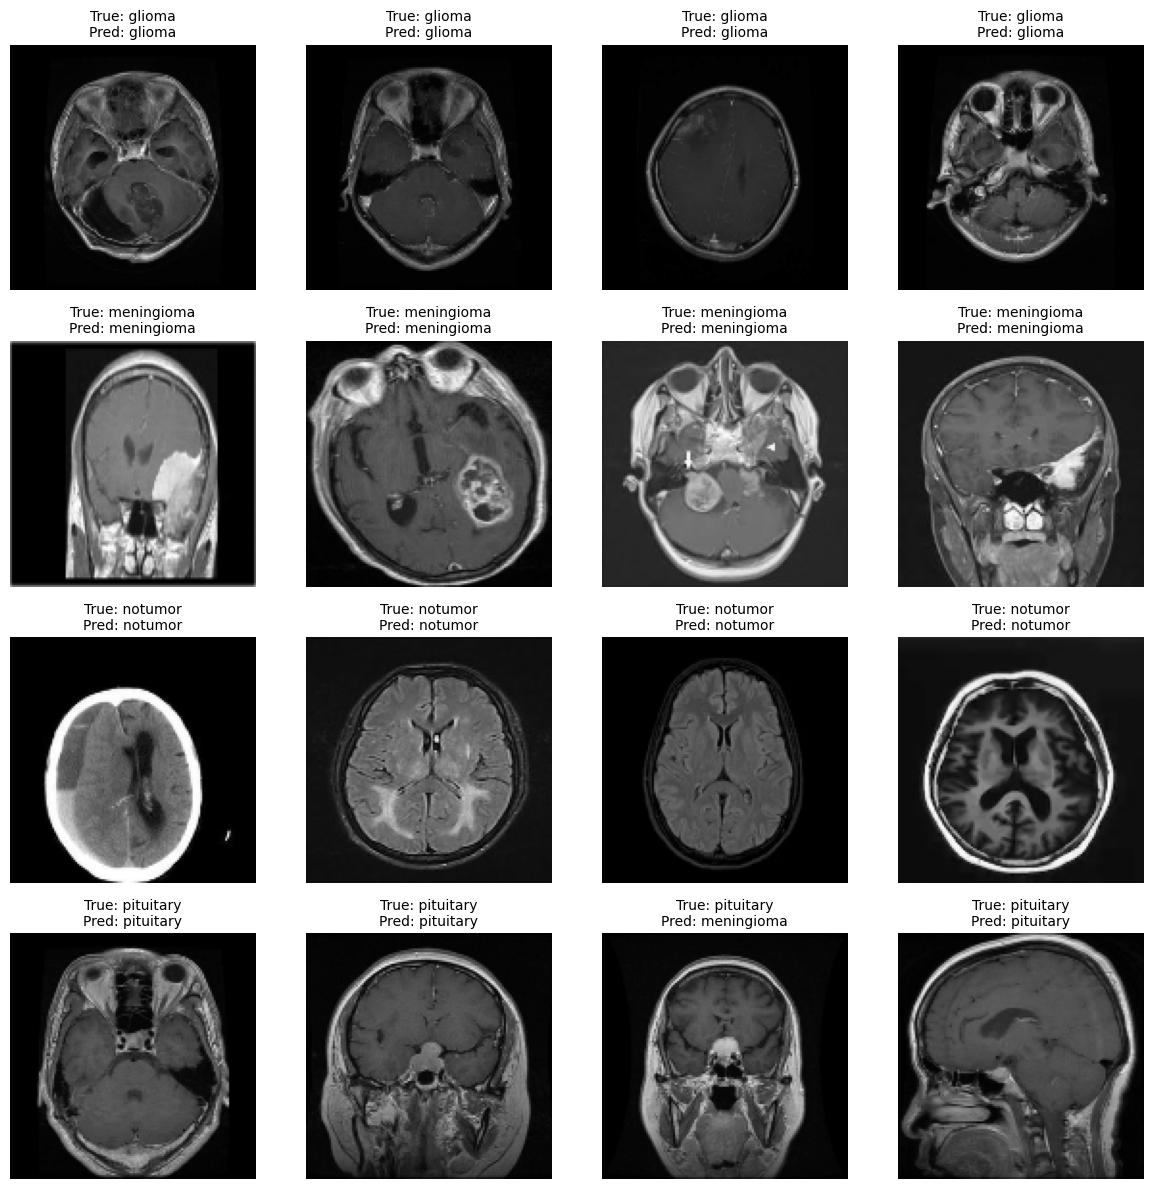

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Initialize a dictionary to store one image per class
unique_images = {i: [] for i in range(len(X_test_labels))}  # Store list of images for each class
num_classes = len(X_test_labels)  # Total number of classes
prediction_count = 4  # Number of times to predict for each image

# Loop through the test dataset to find images from distinct classes
for images, labels in X_test:
    predictions = best_model.predict(images)
    predicted_classes = tf.argmax(predictions, axis=1).numpy()  # Predicted class indices
    true_classes = tf.argmax(labels, axis=1).numpy()  # True class indices

    # Iterate through the batch to store images per class
    for i in range(len(images)):
        true_label = true_classes[i]
        predicted_label = predicted_classes[i]

        # Store image and predicted class 3 times for each true label
        if len(unique_images[true_label]) < prediction_count:
            unique_images[true_label].append((images[i], predicted_label))

        # Break early if all classes are collected
        if all(len(unique_images[label]) == prediction_count for label in unique_images):
            break
    if all(len(unique_images[label]) == prediction_count for label in unique_images):
        break

# Plot the selected images
plt.figure(figsize=(12, 12))
counter = 0
for true_label, image_list in unique_images.items():
    for image, predicted_class in image_list:
        ax = plt.subplot(num_classes, prediction_count, counter + 1)
        plt.imshow(image.numpy())
        true_label_name = X_test_labels[true_label]
        predicted_label_name = X_test_labels[predicted_class]
        plt.title(f"True: {true_label_name}\nPred: {predicted_label_name}", fontsize=10)
        plt.axis("off")
        counter += 1

plt.tight_layout()
plt.show()


In [ ]:
#tensorboard --logdir=./logs